In [2207]:
import sys
import gdsfactory as gf
import numpy as np
import matplotlib.pyplot as plt
from gdsfactory.generic_tech import LAYER

In [2208]:
@gf.cell
def xmon(xmon_length , xmon_width, xmon_spacing, drive_spacing, flux_spacing):
    unit_convert = 1000
    xmon = gf.Component()
    cross = gf.components.cross(xmon_length, xmon_width)
    cross_polygons = cross.get_polygons()[LAYER.WG]
    print(type(cross))
    r1 = gf.kdb.Region(cross_polygons)
    r2 = r1.sized(xmon_spacing*unit_convert)
    r3 = r2 - r1
    xmon.add_polygon(r3, layer=(1,0))
    xmon.add_port(name = 'drive', 
                        center = [(xmon.dxmin - drive_spacing), (xmon.dymin + xmon.dymax)/2],
                        width = 11,
                        orientation = 0,
                        layer = (1,0)
                        )
    xmon.add_port(name = 'flux', 
                        center = [(xmon.dxmin + xmon.dxmax)/2, (xmon.dymin - flux_spacing)],
                        width = 11,
                        orientation = 0,
                        layer = (1,0)
                        )
    return xmon

def resize(shape, size):
    unit_convert = 1000
    shape_polygons = shape.get_polygons()[LAYER.WG] 
    r1 = gf.kdb.Region(shape_polygons)
    r2 = r1.sized(size*unit_convert)
    r3 = r2 - r1
    return r3

def top_connector_mod(connector_length, connector_depth, metal_spacing,size):
    # setting 
    outer_length = connector_length + 2*size + 2*metal_spacing
    outer_width = connector_depth + size + metal_spacing
    inner_length = connector_length + 2*size
    inner_width = connector_depth + size

    c = gf.Component()
    container = gf.Component()
    outer_rect = gf.components.rectangle(size = (outer_length, outer_width))
    inner_rect = gf.components.rectangle(size = (inner_length, inner_width))
    outer_ref = container << outer_rect
    inner_ref = container << inner_rect
    inner_ref.dmove([(outer_length - inner_length) /2, 0])
    C = gf.boolean(A = outer_ref, B = inner_ref, operation='not', layer = (1,0))
    r = resize(C, size)
    c.add_polygon(r, layer=(1,0))
    return c

def get_center(ref):
    return np.array([(ref.dxmax + ref.dxmin)/2, (ref.dymax + ref.dymin)/2])

In [2209]:
unit_convert = 1e3
xmon_length = 450
xmon_width = 48
xmon_spacing = 20

c = gf.Component()
d = gf.Component()
spacing = 4
size = 5
metal_spacing = 15
top_connector = top_connector_mod(connector_length=2*xmon_spacing+xmon_width+2*spacing, connector_depth=60, metal_spacing=metal_spacing, size = size)
top_ref = d << top_connector



# adding ports
drive_spacing = 4
flux_spacing = 3
xmon_ref = c <<xmon(xmon_length=xmon_length, xmon_width=xmon_width, xmon_spacing=xmon_spacing, drive_spacing=drive_spacing, flux_spacing=flux_spacing)

dx = (xmon_ref.dxmax + xmon_ref.dxmin)/2 - (top_ref.dxmax + top_ref.dxmin)/2
dy = xmon_ref.dymax  - top_ref.dymax
top_ref.dmove([dx, dy + size * 2 + metal_spacing + spacing])


boundary = c << gf.components.rectangle(size=(5000, 5000), layer=(2, 0), centered=True, port_type='optical')

<class 'gdsfactory.component.Component'>


In [2210]:
port_width = 10
c.add_port(name='top', center=[(boundary.dxmax+boundary.dxmin)/2, boundary.dymax], width = port_width,orientation=-90, layer = (1,0))
c.add_port(name='right', center=[boundary.dxmax, (boundary.dymax + boundary.dymin)/2], width = port_width,orientation=180, layer = (1,0))
c.add_port(name='bot', center=[(boundary.dxmax+boundary.dxmin)/2, boundary.dymin], width = port_width,orientation=90, layer = (1,0))
c.add_port(name='left', center=[boundary.dxmin, (boundary.dymax + boundary.dymin)/2], width = port_width,orientation=0, layer = (1,0))
c.add_port(name = 'top_connector', center = [(top_ref.dxmax + top_ref.dxmin)/2, top_ref.dymax], width=port_width, orientation=90, layer=(1,0))

Port(name: top_connector, dwidth: 10.0, trans: r90 *1 0,274, layer: 1, port_type: optical)

# creating resonator

In [2211]:
epsilon_r = 11.45
epsilon_eff = (epsilon_r + 1)/2

def calculate_resonator_length(epsilon_eff, frequency):
    c = 299792458
    return c/(4*frequency*np.sqrt(epsilon_eff))

def calculate_resonator_frequency(epsilon_eff, length):
    c = 299792458
    return c/(np.sqrt(epsilon_eff) * 4 * length)

def one_cycle(length, radius):
    P = gf.Path()
    P += gf.path.straight(length=length)
    P += gf.path.arc(radius=radius, angle = 180, npoints=1000)  # Circular arc
    P += gf.path.straight(length=length)  # Straight section
    P += gf.path.arc(radius=radius, angle = -180, npoints=1000)  # Circular arc
    return P.length() 

def create_resonator(length, radius, number_of_cycle):
    P = gf.Path()

    for i in range(int(number_of_cycle)):
        if i == 0:
            P += gf.path.straight(length=length)
            P += gf.path.arc(radius=radius, angle = 90, npoints=100)  # Circular arc
            P += gf.path.straight(length=100)
            P += gf.path.arc(radius=radius, angle=90, npoints=100)

        else:
            P += gf.path.straight(length=length)
            P += gf.path.arc(radius=radius, angle = 180, npoints=100)  # Circular arc
        P += gf.path.straight(length=length)  # Straight section
        P += gf.path.arc(radius=radius, angle = -180, npoints=100)  # Circular arc
    
    P += gf.path.straight(length=length//2-radius)
    P += gf.path.arc(radius=radius, angle = 90, npoints=100)
    P += gf.path.straight(length = 180)
    return P.dmirror((1,0))

def resonator(epsilon_eff, frequency = 6.7e9, length = 300, radius = 30):
    resonator_length_theory = calculate_resonator_length(epsilon_eff, frequency)*1e6
    number_of_cycle = 5
    Path = create_resonator(length, radius, number_of_cycle)
    Path_length = Path.length() + 80
    print(f'Path length: {Path_length} um')
    print('resonator_frequency: ', f'{np.round(calculate_resonator_frequency(epsilon_eff, Path_length*1e-6)/1e9,3)} GHz' )

    resonator_width = 10
    tunnel_width = 6
    s0 = gf.Section(width=resonator_width, offset=0, layer=(1,0))
    s1 = gf.Section(width=tunnel_width, offset=resonator_width/2 + tunnel_width/2, layer=(1, 0))
    s2 = gf.Section(width=tunnel_width, offset=-(resonator_width/2 + tunnel_width/2), layer=(1, 0))
    x = gf.CrossSection(sections=[s1, s2])

    c = gf.path.extrude(Path, cross_section=x)
    return c 

In [2212]:
resonator_qubit_offset = 100
my_resonator = resonator(epsilon_eff)
resonator_ref = c << my_resonator
resonator_ref.dmove((get_center(top_ref) - get_center(resonator_ref)))
resonator_ref.dmove([0, top_ref.dymax - resonator_ref.dymin-5])
resonator_ymax = resonator_ref.dymax

# creating subtraction
subtraction = gf.boolean(top_ref, resonator_ref, operation='and')
merged = gf.boolean(top_ref, resonator_ref, operation='or')
abc = gf.boolean(merged, subtraction, '-')
abc_1 = gf.boolean(merged, abc, '-')

temp = gf.Component()
rec = gf.components.rectangle(size = (10, 5), centered=True)
rec_ref = temp << rec
rec_ref.dmove(
    ( - (rec_ref.dxmin + rec_ref.dxmax)/2 + (abc_1.dxmin + abc_1.dxmax)/2, 
                - (rec_ref.dymin + rec_ref.dxmax)/2 + (abc_1.dymin + abc_1.dymax)/2 + 1.25)
               )

remain = gf.boolean(top_ref, rec_ref, '-')
remain_ref = c << remain

Path length: 4469.565 um
resonator_frequency:  6.721 GHz


# adding pad

In [2213]:
pad = gf.read.import_gds(gdspath='pad.gds')

pad.add_port('back', center=[pad.dxmin,(pad.dymax + pad.dymin)/2], layer=(1,0), width=10, orientation=180)
pad.add_port('front', center=[pad.dxmax,(pad.dymax + pad.dymin)/2], layer = (1,0), width=10, orientation=0)

left_pad = c << pad
left_pad.connect("back", c.ports['left'], allow_layer_mismatch=True)

pad = gf.read.import_gds(gdspath='bot-connector.gds')
pad.add_port('back', center=[pad.dxmin,(pad.dymax + pad.dymin)/2], layer=(1,0), width=10, orientation=180)
pad.add_port('front', center=[pad.dxmax,(pad.dymax + pad.dymin)/2], layer = (1,0), width=10, orientation=0)
bot_pad = c << pad
bot_pad.connect("back", c.ports['bot'], allow_layer_mismatch=True)


In [2214]:
pad = gf.read.import_gds(gdspath='pad_transmission.gds')

pad.add_port('back', center=[pad.dxmin,(pad.dymax + pad.dymin)/2], layer=(1,0), width=10, orientation=180)
pad.add_port('front', center=[pad.dxmax,(pad.dymax + pad.dymin)/2], layer = (1,0), width=10, orientation=0)

top_pad = c << pad
top_pad.connect("back", c.ports['top'], allow_layer_mismatch=True)
right_pad = c << pad
right_pad.connect("back", c.ports['right'], allow_layer_mismatch=True)

# transmission line routing

In [2215]:
inner = gf.Component()
outer = gf.Component()
tranmission_width = 20
tranmission_tunnel_width = 12
tranmission_resonator_offset = 4
xs_1 = gf.cross_section.cross_section(width=tranmission_width, layer=(1,0))
xs_2 = gf.cross_section.cross_section(width=tranmission_width + 2*tranmission_tunnel_width, layer=(1,0))


tranmission_turn = 800
y_pos = resonator_ymax + tranmission_turn - 200 
y_pos2 = resonator_ymax + tranmission_width/2 + tranmission_tunnel_width + tranmission_resonator_offset

route_inner = gf.routing.route_single_from_steps(
    inner, 
    port1 = top_pad.ports['front'],
    port2 = right_pad.ports['front'],
    allow_width_mismatch = False,
    cross_section = xs_1,
    steps = [
        {"x": 0, "y": y_pos},
        {"x": -500, "y": y_pos},
        {"x": -500, "y": y_pos2},
        {"x": y_pos2, "y": y_pos2},
        {"x": y_pos2, "y": 0},
    ],
    radius = 50,
)

route_outer = gf.routing.route_single_from_steps(
    outer, 
    port1 = top_pad.ports['front'],
    port2 = right_pad.ports['front'],
    allow_width_mismatch = False,
    cross_section = xs_2,
    steps = [
        {"x": 0, "y": y_pos},
        {"x": -500, "y": y_pos},
        {"x": -500, "y": y_pos2},
        {"x": y_pos2, "y": y_pos2},
        {"x": y_pos2, "y": 0},
    ],
    radius = 50,
)

In [2216]:
tunnel = gf.boolean(A=outer, B = inner, operation='A-B', layer=(1,0))
tunnel_ref = c << tunnel

# drive outing

In [2217]:
drive_xmon = gf.read.import_gds(gdspath='drive-xmon.gds')

drive_xmon.add_port('back', center=[drive_xmon.dxmin,(drive_xmon.dymax + drive_xmon.dymin)/2], layer=(1,0), width=10, orientation=180)
drive_xmon.add_port('front', center=[drive_xmon.dxmax,(drive_xmon.dymax + drive_xmon.dymin)/2], layer = (1,0), width=10, orientation=180)

drive_xmon_ref = c << drive_xmon
drive_xmon_ref.connect("front", xmon_ref.ports['drive'], allow_layer_mismatch=True, allow_width_mismatch=True)

inner = gf.Component()
outer = gf.Component()
tranmission_width = 10 
tranmission_resonator_offset = 4
xs_1 = gf.cross_section.cross_section(width=tranmission_width, layer=(1,0))
xs_2 = gf.cross_section.cross_section(width=tranmission_width + tranmission_tunnel_width, layer=(1,0))


route_inner = gf.routing.route_single(
    inner, 
    port1 = left_pad.ports['front'],
    port2 = drive_xmon_ref.ports['back'],
    allow_width_mismatch = True,
    cross_section = xs_1,
    radius = 50,
)

route_outer = gf.routing.route_single(
    outer, 
    port1 = left_pad.ports['front'],
    port2 = drive_xmon_ref.ports['back'],
    allow_width_mismatch = True,
    cross_section = xs_2,
    radius = 50,
)

drive_tunnel = gf.boolean(A=outer, B = inner, operation='A-B', layer=(1,0))
drive_tunnel_ref = c << drive_tunnel

# flux routing

In [2218]:

flux_xmon = gf.read.import_gds(gdspath='flux-xmon.gds')

flux_xmon.add_port('top', center=[(-3+1)/2, flux_xmon.dymax], layer=(1,0), width=10, orientation=180)
flux_xmon.add_port('bot', center=[(-3+1)/2,flux_xmon.dymin], layer = (1,0), width=10, orientation=270)

flux_xmon_ref = c << flux_xmon
flux_xmon_ref.connect("top", xmon_ref.ports['flux'], allow_layer_mismatch=True, allow_width_mismatch=True)

inner = gf.Component()
outer = gf.Component()
tranmission_width = 10
tranmission_tunnel_width = 5
xs_1 = gf.cross_section.cross_section(width=tranmission_width, layer=(1,0))
xs_2 = gf.cross_section.cross_section(width=tranmission_width + 2*tranmission_tunnel_width, layer=(1,0))


route_inner = gf.routing.route_single(
    inner, 
    port1 = bot_pad.ports['front'],
    port2 = flux_xmon_ref.ports['bot'],
    allow_width_mismatch = True,
    cross_section = xs_1,
    radius = 50,
)

route_outer = gf.routing.route_single(
    outer, 
    port1 = bot_pad.ports['front'],
    port2 = flux_xmon_ref.ports['bot'],
    allow_width_mismatch = True,
    cross_section = xs_2,
    radius = 50,
)

flux_tunnel = gf.boolean(A=outer, B = inner, operation='A-B', layer=(1,0))
flux_tunnel_ref = c << flux_tunnel

In [2219]:
c.write_gds('qudit-version0-0708.gds')

WindowsPath('qudit-version0-0708.gds')

In [54]:
import numpy as np
# Constants
h_bar = 1.0545718e-34  # Planck constant over 2pi in Js
phi_0 = 2.067833831e-15  # Magnetic flux quantum in Wb
e = 1.60217662e-19  # Elementary charge in C
Zr = 50  # Ohm, characteristic impedance of the resonator
h = h_bar * 2*np.pi
c = 1.647e-13
qubit_f = 4.5e9
resonator_f = 6.70e9
Delta = resonator_f - qubit_f
Qext = 11502
E_c = e**2 / (2*c)
alpha = E_c/h

kappa = resonator_f/Qext
kai = kappa/2
g = np.sqrt(kai * Delta * ((alpha + Delta) / alpha)) 

def calculate_Ej(qubit = qubit_f, Ec = E_c):
    return (qubit*h + Ec)**2/(8*Ec)

Ej = calculate_Ej()
phi_0 = h/(2*e)
I_c = Ej*2*np.pi/phi_0
jj_area = I_c/(0.5e-6)/2
jj_width = jj_area/0.2

print(f'Critical Current I_c: {I_c*1e6} uA')
print(f'JJ area: {jj_area} um^2')
print(f'JJ width: {jj_width} um')
print(f'Xmon Capacitance: {c*1e5} fF')
print(f'Anharmonicity: {alpha/1e6} MHz')
print(f'Ej/Ec ratio: {calculate_Ej()/E_c}')
print(f'Qubit Frequency: {qubit_f/1e9} GHz')
print(f'Resonator Frequency: {resonator_f/1e9} GHz')
print(f"kappa (Decay rate): {kappa:.2e} Hz")
print(f"1/kappa (Decay time): {1/kappa*1e9:.2e} ns")
print(f"Dispersive shift: {kai*1e-6 :.2e} MHz")
print(f"g (Coupling strength): {g * 1e-6:.2f} MHz")


Critical Current I_c: 0.04562716096122092 uA
JJ area: 0.04562716096122092 um^2
JJ width: 0.2281358048061046 um
Xmon Capacitance: 1.6469999999999998e-08 fF
Anharmonicity: 117.60916399673832 MHz
Ej/Ec ratio: 192.69126589187852
Qubit Frequency: 4.5 GHz
Resonator Frequency: 6.7 GHz
kappa (Decay rate): 5.83e+05 Hz
1/kappa (Decay time): 1.72e+03 ns
Dispersive shift: 2.91e-01 MHz
g (Coupling strength): 112.37 MHz


In [2]:
import gdsfactory as gf
# Load the GDS file
try:
    gds_file = gf.import_gds("qudit-version0-0708.gds")
    print("GDS file loaded successfully.")
except Exception as e:
    print(f"Error loading GDS file: {e}")

GDS file loaded successfully.


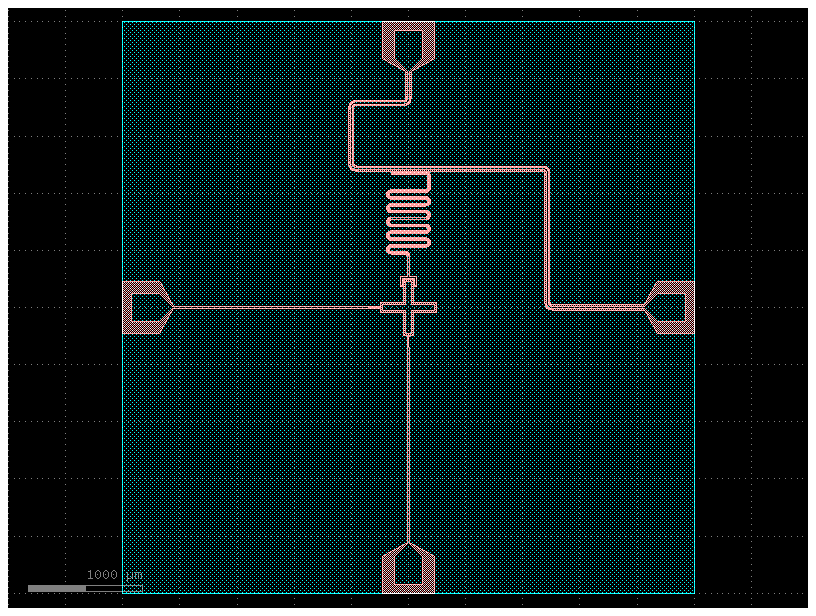

In [3]:
gds_file.plot()

In [1]:
import gdsfactory as gf

c = gf.components.delay_snake(length=1600, length0=0, length2=0, n=4, cross_section='strip')

In [42]:
def JJ(FINGER_length):
    assert (FINGER_length >= 0.1 and FINGER_length <= 6)

    canvas_jj = gf.Component()
    left_rectangle_ref = canvas_jj << gf.components.rectangle(size=(14,4), port_type='optical', layer=(3,0))
    taper = gf.components.taper2(
        length=0.5, 
        width1=4, 
        width2=FINGER_length, 
        with_two_ports=True, 
        cross_section='strip', 
        port_names=('o1', 'o2'), 
        port_types=('optical', 'optical'), 
        with_bbox=True,
        layer = (3,0))
    taper_ref = canvas_jj << taper
    taper_ref.connect("o1", left_rectangle_ref.ports['o3'], allow_layer_mismatch=True)
    finger_ref = canvas_jj << gf.components.rectangle(size=(1.36, FINGER_length), port_type='optical', layer = (3,0))
    finger_ref.connect("o1", taper_ref.ports['o2'], allow_layer_mismatch = True)
    
    right_rectangle_ref = canvas_jj << gf.components.rectangle(size=(16,4), port_type='optical', layer=(3,0))
    right_rectangle_ref.dmove(( finger_ref.dxmax + 0.14, 0 ))

    return canvas_jj

2024-07-12 15:32:08.394 | WARNING  | gdsfactory.component:__getattribute__:128 - Getting `Unnamed_62_16000_2000.rotate` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_62_16000_2000.drotate` instead. For further information, please consult the migration guide https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html
2024-07-12 15:32:08.395 | WARNING  | gdsfactory.component:__getattribute__:128 - Getting `Unnamed_62_16000_2000.rotate` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_62_16000_2000.drotate` instead. For further information, please consult the migration guide https://gdsfactory.github.io/gdsfactory/notebooks/21_migration_guide_7_8.html


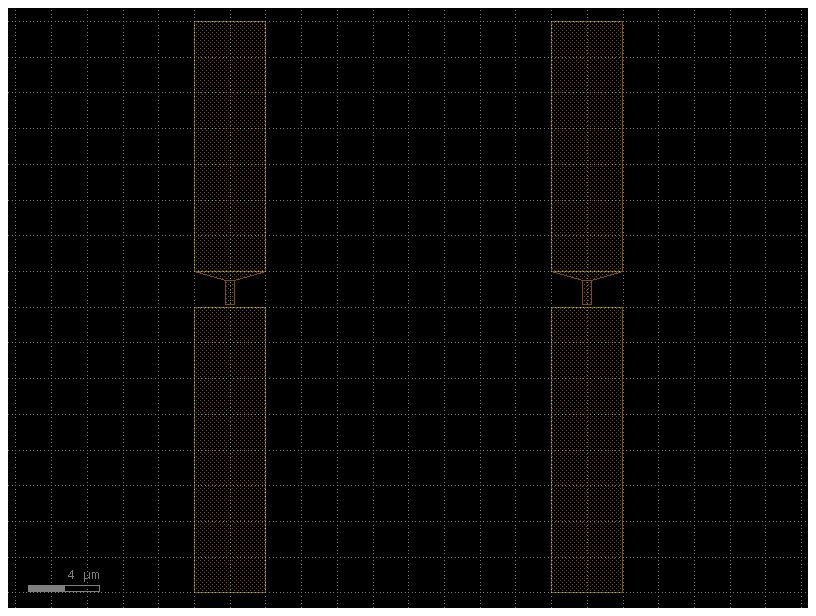

In [53]:
canvas = gf.Component()
jj = JJ(0.5)
jj_ref1 = canvas << jj
jj_ref2 = canvas << jj
jj_ref1.rotate(-90)
jj_ref2.rotate(-90)
jj_ref2.dmovex(20)
canvas.plot()